The NBA playoffs are coming soon and the brckets are almost completely set. This notebook aims to make predictions for these playoffs.

This project delivers value by:
- revealing indicators of success that tend to appear in the NBA
- providing data to identify strategies that need to be adjusted

In [1]:
import sqlalchemy
from os import environ

import numpy as np
import pandas as pd

The data used in this projects are the traditional team box scores during the regular and postseasons from the 1989-90 to 2020-21. These box scores represent the team's sum (in the case of percentages, the total percentages) of each statistic in a game.

Data was sourced from the NBA's official website: https://www.nba.com/stats/teams/boxscores/

The data is stored locally in a MySQL database and is imported as follows:

In [2]:
engine = sqlalchemy.create_engine("mariadb+mariadbconnector://"+environ.get("USER")+\
                                  ":"+environ.get("PSWD")+"@127.0.0.1:3306/nba")

In [3]:
command = "SELECT Teams.Name AS Team, Team_box_scores.* FROM Team_box_scores"+\
" INNER JOIN Teams ON Team_box_scores.Team_ID = Teams.ID "

df = pd.read_sql(command,engine)

In [4]:
drop_columns = ['Team_ID']
df.drop(columns=drop_columns,inplace = True)

Season_type will be used to differentiate regular season from playoffs. Variable gdf.index is a tuple of size 3 of the format: (Team, season_type, year)

In [5]:
df["Season_type"] = df["Game_ID"].str.slice(0,3) # first three digits represent the season type
df["Year"] = df["Game_ID"].str.slice(3,2) # 4th and 5th digit represent year the season started
df['Playoffs'] = True 

In [6]:
gdf = df.groupby(['Team','Season_type','Year']).count()

Change Playoffs variable to 0 if there is no playoff data for that team that year.

In [7]:
for t,s,y in gdf.index:
    if(s=='004'):
        l = gdf.loc[t].loc[s].index
        df.loc[df['Team']==t,"Playoffs"] = df.loc[df['Team']==t,"Playoffs"].where(df["Year"].isin(l),False)

Now that the playoff status has been established, the temporary variables can be removed

In [8]:
drop_cols = ['Season_type','Year']
df.drop(columns = drop_cols,inplace=True)

# Basic exploration

The data is clean with only 3 null values for the variable P3P (3P%) which means that there were three games over the last 33 years in which a team did not attempt 3 point shots. These null values for P3P can be replaced with a 0 because in this case, it is semantically the same thing.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79504 entries, 0 to 79503
Data columns (total 25 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Team      79504 non-null  object 
 1   Game_ID   79504 non-null  object 
 2   Matchup   79504 non-null  object 
 3   Game_day  79504 non-null  object 
 4   Result    79504 non-null  object 
 5   MINS      79504 non-null  int64  
 6   PTS       79504 non-null  int64  
 7   FGM       79504 non-null  int64  
 8   FGA       79504 non-null  int64  
 9   FGP       79504 non-null  float64
 10  PM3       79504 non-null  int64  
 11  PA3       79504 non-null  int64  
 12  P3P       79504 non-null  float64
 13  FTM       79504 non-null  int64  
 14  FTA       79504 non-null  int64  
 15  FTP       79504 non-null  float64
 16  OREB      79504 non-null  int64  
 17  DREB      79504 non-null  int64  
 18  REB       79504 non-null  int64  
 19  AST       79504 non-null  int64  
 20  TOV       79504 non-null  in

In [10]:
df.fillna(value={'P3P':0},inplace=True)

Below is the histogram for each numeric variable

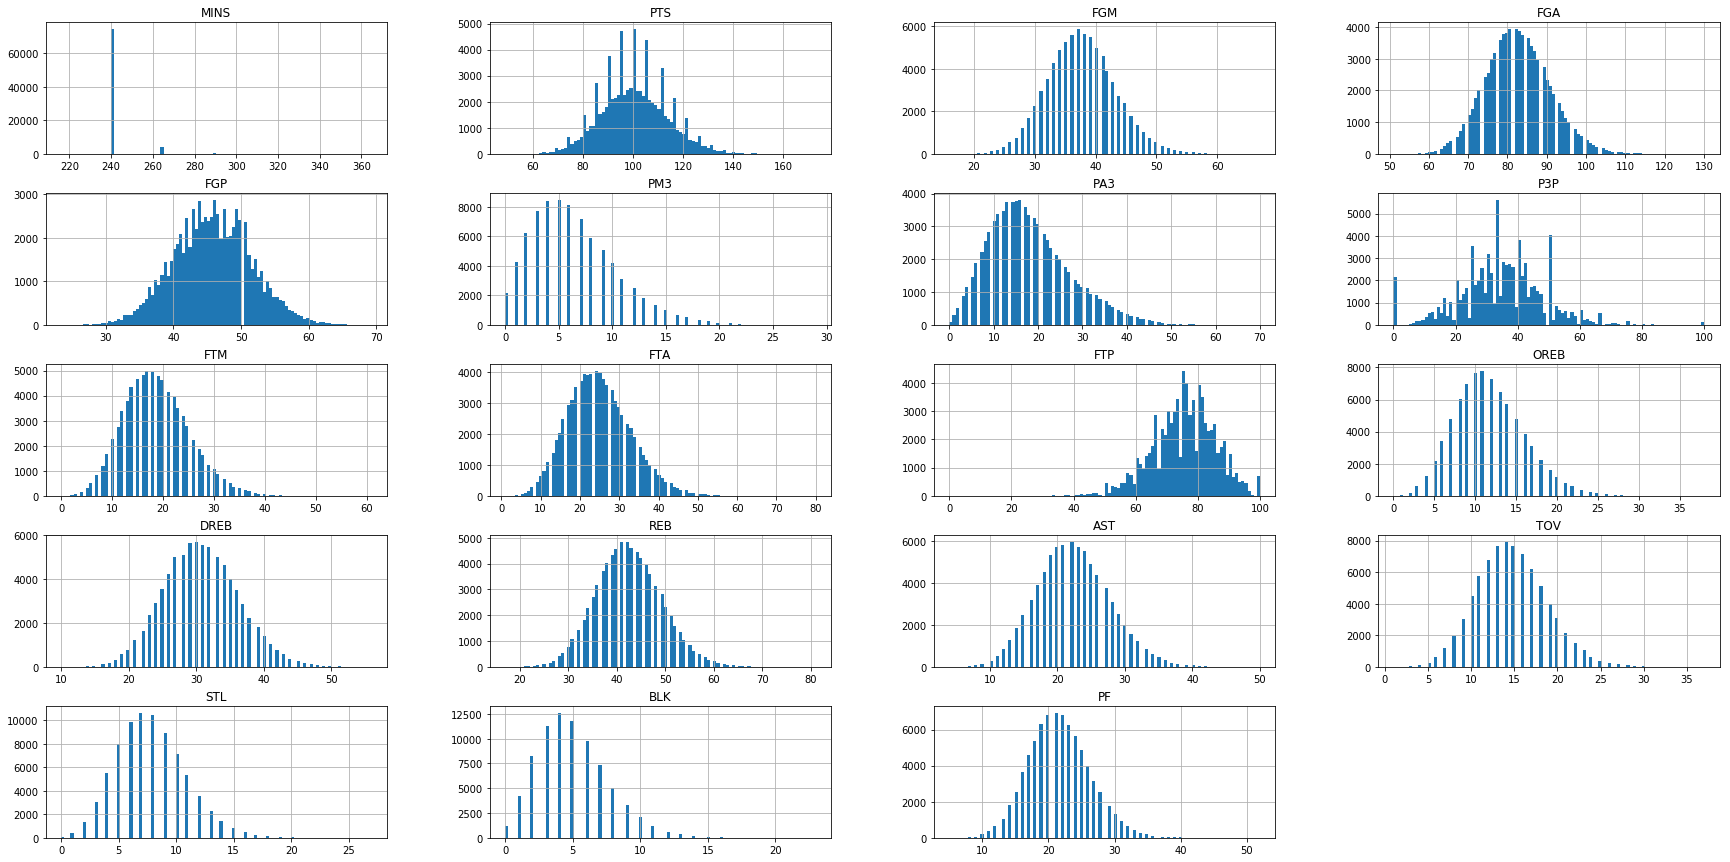

In [13]:
import matplotlib.pyplot as plt
df.hist(bins = 100,figsize=(30,15))
plt.show()

With the exception of the Minutes played, all other numeric statistics are roughly normally distributed. This pattern is typical throughout basketball (from team performance to individual performance) and it is this property that that will be useful for a number of machine learning methods.

Minutes played will not follow a normal distribution because most games typically end in regulation and increasingly less every subsequent overtime period. It may be difficult to use minutes played as a predictor to make the playoffs.

# Test set allocation
Best practice dictates that a test set must now be created and unseen the until models can be tested.

Since there are a large number of records $\approx$ 80K, the data can be randomly sampled. The test size will be 20% of the data. This will be used to evaluate the final model. For reprducability, the random seed will be 10.

Model selection will be done using cross-validation.

In [14]:
from sklearn.model_selection import train_test_split
SEED = 10
test_size = .2

In [16]:
features = ['Result', 'MINS', 'PTS', 'FGM', 'FGA', 'FGP', 'PM3', 'PA3', 'P3P','FTM','FTA',
              'FTP', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK','PF']
dependent = ['Playoffs']
X = df[features]
Y = df[dependent]

In [17]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,random_state=SEED,test_size=test_size)

# Exploratory analysis

Since teams are ranked within their conference, it could be useful to include the conference a team competes in.

In [18]:
conferences = {'West':['NOP','UTA', 'MEM','PHX', 'POR', 'SAC', 'SAS', 'OKC','DAL', 'DEN', 'GSW', 'HOU','LAC', 'LAL','MIN'],
               'East':[]}

In [19]:
conferences['East'] = [i for i in df['Team'].unique() if i not in conferences['West']]

In [20]:
conferences

{'West': ['NOP',
  'UTA',
  'MEM',
  'PHX',
  'POR',
  'SAC',
  'SAS',
  'OKC',
  'DAL',
  'DEN',
  'GSW',
  'HOU',
  'LAC',
  'LAL',
  'MIN'],
 'East': ['ATL',
  'BOS',
  'CLE',
  'CHI',
  'MIA',
  'MIL',
  'BKN',
  'NYK',
  'ORL',
  'IND',
  'PHI',
  'TOR',
  'WAS',
  'DET',
  'CHA']}